In [1]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [11]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
gitpath = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
df = pd.read_csv(get_path(path = gitpath) + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

### Functions used to calculate information gain, plot use, etc...

In [12]:
def add_text(attribute,family_category,cut_off, shortest_seq_length, longest_seq_length,B):
    text = """Showing sequences for students split by {0}, using the categories {1}.
            Removed sequences used by less than {2}% of students.
            Found sequences of lenght {3} to {4}.
            Using {5} time bins""".format(attribute,family_category,int(cut_off*100), shortest_seq_length, longest_seq_length,B)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.text(0.5,0.5,text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize = 15)
    plt.axis('off')
    return fig


def plot_heat_map(data, title, ylabels, DisplayXProb = True, DisplayYProb = True, show_cbar=True):

    ''' 
    This function plots a heat map given a 2D numpy array.  The array elements relate 
    to the amount of times a certain sequence of actions is used by students belonging to a 
    certain group at a certain time segment of their activity.
    
    Arguments:
    data: 2D numpy array (data.shape = n*m, where n is len(ylabels) and m is whatever time segment resolution used)
    
    ylabels: list of strings to label the y-axis of heat-map (i.e. the 2 student groups compared)
    By default plot_heat_map will also display the probabilities used in entropy calc corresponding
    to each row and column of data array (on the side of the plot opposite the x/ylabels).
    i.e. probabilities that sequence is used by a certain group over all time 
    and probabilities that sequence is used for a certain time segment over all groups 
    
    show_cbar: show colorbar to the left of plot
    '''

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.8, vmin=0)

    #set title
    ax.set_title(title,y=1,loc='left',fontsize=14)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ax.set_xticks(np.arange(data.shape[1]) + 0.5)

    # Set the labels
    xlabels = map(str, np.arange(data.shape[1])+1) 
#     ax.set_xticklabels(xlabels, fontweight='bold')
    ax.set_xticklabels([],)
    ax.set_yticklabels(ylabels, fontweight='bold')

    # Create new axes that will show probability that sequence is used by a certain group over all time 
    total = np.sum(data).astype(float) #total number of students that used sequence
    if DisplayXProb == True:
        probx = np.sum(data, axis=0)/total
        xlabels2 = list("%.2f" % px for px in probx)
        ax2 = ax.twiny()
        ax2.xaxis.tick_bottom()
        ax2.invert_yaxis()
        ax2.set_frame_on(False)
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(np.arange(data.shape[1]) + 0.5)
        ax2.set_xticklabels(xlabels2)
        ax2.tick_params(
            axis='x',           # changes apply to both the x and y-axis
            which='both',       # both major and minor ticks are affected
            bottom='off',       # ticks along the those edges are off
            top='off') 

    # Create new axes that will show probability that sequence is used for a certain time segment over all groups 
    if DisplayYProb == True:
        proby = np.sum(data, axis=1)/total
        ylabels3 = list("%.2f" % py for py in proby)
        ax3 = ax.twinx()
        ax3.set_frame_on(False)
        ax3.set_ylim(ax.get_ylim())
        ax3.set_yticks(np.arange(data.shape[0]) + 0.5)
        ax3.set_yticklabels(ylabels3)	
        ax3.tick_params(
            axis='y',           # changes apply to both the x and y-axis
            which='both',       # both major and minor ticks are affected
            right='off',        # ticks along the those edges are off
            left='off') 

    # put time labels on top
    ax.xaxis.tick_top()
    # figure size 
    fig.set_size_inches(10, 4)
    # turn off the frame
    ax.set_frame_on(False)
    # rotate the xticks labels if needed
    # plt.xticks(rotation=90)
    # Turn off all the ticks
    ax.tick_params(
        axis='both',        # changes apply to both the x and y-axis
        which='both',       # both major and minor ticks are affected
        bottom='off',       # ticks along the those edges are off
        right='off', 
        left='off',
        top='off') 
    
    if show_cbar == True: # Add colorbar
        cbaxes = fig.add_axes([0.95, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
        cbar = fig.colorbar(heatmap, cax=cbaxes)
#         cbarticks = [np.amin(data),(np.amin(data)+np.amax(data))/2,np.amax(data)]
#         cbar.set_ticks(cbarticks)
#         cbar.set_ticklabels(map(str, cbarticks))
    
    return fig

In [13]:
def rank_sequences(sequence_counts,B,axesnum=None):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
#         if np.sum(counts)>0:
        ranks.append((seq,calc_infogain(counts,B,axesnum)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

### Let's investigate how best to split students

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E334518>]], dtype=object)

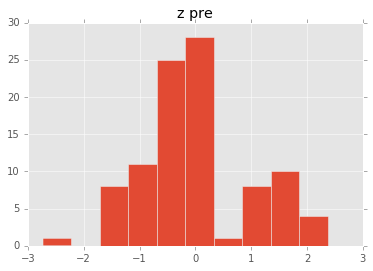

In [14]:
df_scores.hist(column='z pre')

#### Clearly, students' pre test is a bi modal distribution. Let's split them this way.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000EF5F320>]], dtype=object)

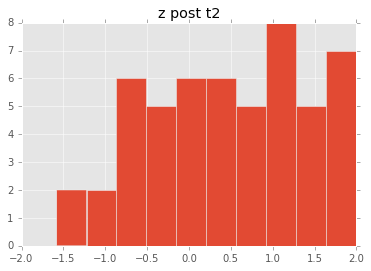

In [15]:
def label_learning (median,row,column):
    if row[column] >= median: return 'high'
    else: return 'low'
    
median_learning1 = np.median(df_scores['z post t1'])
df_scores['split_post_t1'] = df_scores.apply (lambda row: label_learning (median_learning1,row,"z post t1"),axis=1)
df_scores[df_scores['split_post_t1']=='high'].hist(column='z post t2')

In [16]:
median_learning1 = 0.45
df_scores['split pre'] = df_scores.apply (lambda row: label_learning (median_learning1,row,"z pre"),axis=1)
median_learning1 = np.median(df_scores[df_scores['split pre']=='low']['z post t2'])
df_scores['split post t2'] = df_scores.apply (lambda row: label_learning (median_learning1,row,"z post t2"),axis=1)

In [17]:
for x in ['high','low']:
    for y in ['high','low']:
        print x,y, len(set(df_scores[(df_scores['split pre']==x)&(df_scores['split post t2']==y)]['student']))

high high 19
high low 3
low high 38
low low 36


In [18]:
a = set(get_students('split post t2','high'))
b = set(get_students('used this circuit sim before?',1))
c = set(get_students('split post t2','low'))
print len(a), len(b), len(a.intersection(b)), len(c.intersection(b))

57 37 20 17


### We can calculate the information gain of each sequence by time bin 
given a split by pre test

In [19]:
### if redoing this analysis, fix algorithm wot use frequency of use in each time bin because we have unequal groups

# students = get_students()
# CUT_OFF = 0.35 #we keep only sequences used once by at least 20% of students
# shortest_seq_length = 2
# longest_seq_length = 10
# BINS = 4  #number of bins

# ### PARAMETERS
# attributes = [('split pre','high','low')]
# family_categories = ["Family","Family_tool","Family_default"]

# parse_axis = {0:'time',1:'group',None:'time and group'}
# pdf = PdfPages('infogain_results_by_pre.pdf')

# for attribute,level1,level2 in attributes:
#     for family_category in family_categories:
#         for axis in [0,1,None]:
#             if axis == 1: B = 1
#             else: B = BINS
        
#             print "For attribute {0}, category {1}".format(attribute,family_category)
#             pdf.savefig(add_text(attribute,family_category,CUT_OFF, shortest_seq_length, longest_seq_length,B))
#             sequence_counts = get_sequence_use_by_timebin(df,students,family_category,
#                                                           B,attribute,level1,level2,
#                                                           shortest_seq_length,longest_seq_length,CUT_OFF)
#             print len(sequence_counts)
#             ylabels = [level1,level2]
#             tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),5)
#             for seq,infogain in tops:
# #                 print seq, sequence_counts[seq]
#                 title = '{0}: infogain {1} by {2}'.format(seq,round(infogain,3),parse_axis[axis])
#                 plot = plot_heat_map(sequence_counts[seq],title, ylabels)
#                 pdf.savefig( plot )
#                 plot.clf()
# pdf.close()

### We can calculate the information gain of each sequence by time bin 
given a split by post test, for only students that did poorly on pre test

For attribute split post t2, categories Family
Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.
time
TbC 0.329710067072
CTsPTsP 0.35966393524
TbP 0.386342654305
PCTsP 0.429140315277
TbPC 0.487644769003
CTbP 0.669149092294
CTbCTb 0.735268270796
CTbPC 0.787940532869
TbCTb 0.940512648262
TbCP 0.986336487441
TbCPC 1.01357327127
CTbCP 1.04323429163
PTb 1.08876077736
TbCTbP 1.22575669708
CPTb 1.74198133134
For attribute split post t2, categories Family
Getting sequence use over 1 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.
group
TcPCTcC 0.0505479846121
CPCTcC 0.0519217564061
TsPCP 0.0543396953994
TcCTcCTc 0.0573168107445
TcCPC 0.0678884323833
TsPTsP 0.0817041659455
CPTsP 0.0817041659455
TsCTsC 0.0817041659455
CPTs 0.097606717205
PTsP 0.142851562572
CTsPTsP 0.147594

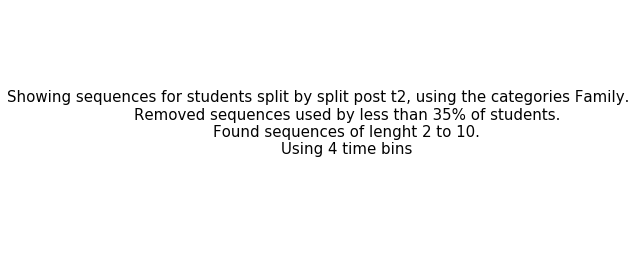

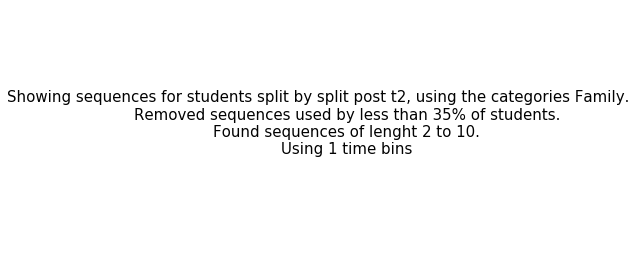

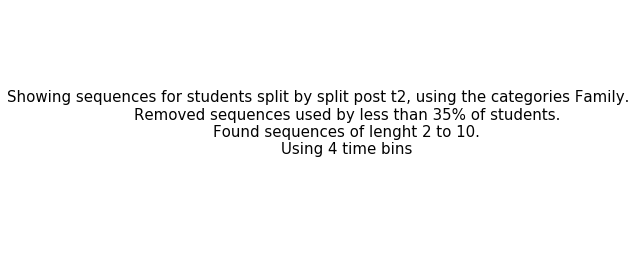

In [27]:
students = get_students(attribute='split pre',level='low')
CUT_OFF = 0.35 #we keep only sequences used once by at least 10% of students
shortest_seq_length = 2
longest_seq_length = 10
BINS = 4  #number of bins

### PARAMETERS
attributes = [('split post t2','high','low')]
family_categories = ["Family"]#,"Family_tool","Family_default"]

parse_axis = {0:'time',1:'group',None:'time and group'}
pdf = PdfPages('infogain_results_by_post2.pdf')

for attribute,level1,level2 in attributes:
    for family_category in family_categories:
        for axis in [0,1,None]:
            if axis == 1: B = 1
            else: B = BINS
        
            print "For attribute {0}, categories {1}".format(attribute,family_category)
            pdf.savefig(add_text(attribute,family_category,CUT_OFF, shortest_seq_length, longest_seq_length,B))
            sequence_counts = get_sequence_use_by_timebin(df,students,family_category,
                                                          B,attribute,level1,level2,
                                                          shortest_seq_length,longest_seq_length,CUT_OFF)
            ylabels = [level1,level2]
            tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),15)
            print parse_axis[axis]
            for seq,infogain in tops:
                print seq, infogain
                title = '{0}: infogain {1} by {2}'.format(seq,round(infogain,3),parse_axis[axis])
                plot = plot_heat_map(sequence_counts[seq],title, ylabels)
                pdf.savefig( plot )
                plot.clf()
pdf.close()

### We repeat the same analysis, only remove the first time bin before to see if what students do in other time bins differentiates them as well (though not as significantly).

In [21]:
# parse_axis = {0:'time',1:'group',None:'time and group'}

# pdf = PdfPages('infogain_results_no_first_bin.pdf')

# for attribute,level1,level2 in attributes:
#     for family_category in family_categories:
#         for axis in [0,1,None]:
#             if axis == 1:
#                 B = 1
#             else:
#                 B = 3
        
#             print "For attribute {0}, categories {1}".format(attribute,family_category)
#             pdf.savefig(add_text(attribute,family_category,N, shortest_seq_length, longest_seq_length,B))
#             sequence_counts = get_sequence_use_by_timebin(df,students,family_category,B,attribute,level1,level2,shortest_seq_length,longest_seq_length,N)
#             sequence_counts = remove_first_bin(sequence_counts)
#             ylabels = [level1,level2]
#             tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),1)
#             for seq,infogain in tops:
#                 print seq, sequence_counts[seq]
#                 title = '{0}: infogain {1} by {2}'.format(seq,round(infogain,3),parse_axis[axis])
#                 plot = plot_heat_map(sequence_counts[seq],title, ylabels)
#                 pdf.savefig( plot )
#                 plot.clf()
# pdf.close()

In [22]:
# def remove_first_bin(sequence_counts):
#     new_seq_counts = {}
#     for s,c in sequence_counts.iteritems():
#         new_seq_counts[s] = c[:,1:]
#     return new_seq_counts  

In [23]:
students = get_students(attribute='split pre',level='low')
CUT_OFF = 0.35 #we keep only sequences used once by at least 35% of students
shortest_seq_length = 2
longest_seq_length = 10
B = 1  #number of bins

### PARAMETERS
attribute, level1, level2 = ('split post t2','high','low')
family_category = "Family"
sequence_counts = get_sequence_use_by_timebin(df,students,family_category,
                                                          B,attribute,level1,level2,
                                                          shortest_seq_length,longest_seq_length,CUT_OFF)

Getting sequence use over 1 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


Figure(800x320)


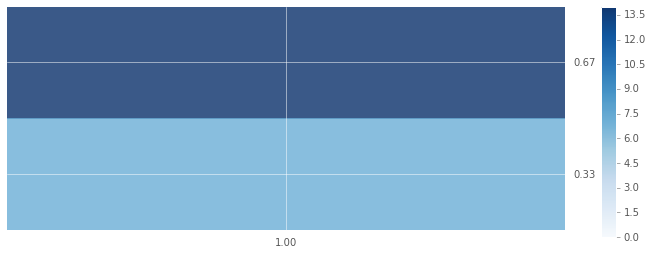

In [24]:
print plot_heat_map(sequence_counts['TsPTsP'],'','')